# **MIP 연속변수사용**

In [ ]:
# 필요한 라이브러리 설치
!pip install pulp openpyxl

import pandas as pd
import numpy as np
from pulp import LpProblem, LpMinimize, LpVariable, lpSum, LpBinary, LpContinuous
import warnings
from openpyxl import Workbook

# 파일 경로
input_file = '/content/sample_data/NW_MasterData.xlsx'
output_file = '/content/sample_data/OptimizationResult수정MIP.xlsx'

# 데이터 로드
city_df = pd.read_excel(input_file, sheet_name='City')
cost_df = pd.read_excel(input_file, sheet_name='Cost')
distance_df = pd.read_excel(input_file, sheet_name='Distance')

# 상수 정의
inventory_turnover = 12
fixed_distance = 16
num_selected_wh = 3

# 도시 및 창고 목록
cities = city_df['City'].tolist()
warehouses = cost_df['WH'].tolist()

# 거리 딕셔너리 생성
distance_dict = {(row['FromCity'], row['ToCity']): row['Distance'] for _, row in distance_df.iterrows()}

# 변수 초기화
transport_cost = {}
inbound_cost = {}

for city_row in city_df.itertuples():
    city = city_row.City
    demand = city_row.Cargo
    for wh_row in cost_df.itertuples():
        wh = wh_row.WH
        dist = distance_dict.get((wh, city), fixed_distance if wh == city else None)
        if dist is None:
            warnings.warn(f"Distance missing: {wh} to {city}")
            continue
        t_cost = demand * dist * wh_row.TruckUnitRate
        i_cost = demand * wh_row.InboundRate
        transport_cost[(city, wh)] = t_cost
        inbound_cost[(city, wh)] = i_cost

# 모델 정의
model = LpProblem("Warehouse_Optimization", LpMinimize)

# 변수 정의
x = LpVariable.dicts("assign", (cities, warehouses), cat=LpBinary)
y = LpVariable.dicts("select", warehouses, cat=LpBinary)
z = LpVariable.dicts("total_demand", warehouses, lowBound=0, cat=LpContinuous)

# 목적함수 정의 (연속변수 z[w] 기반 창고비 반영)
model += (
    lpSum([
        (transport_cost[(c, w)] + inbound_cost[(c, w)]) * x[c][w]
        for c in cities for w in warehouses if (c, w) in transport_cost
    ]) +
    lpSum([
        z[w] * cost_df[cost_df['WH'] == w]['WHUnitRate'].values[0] * 12 * np.sqrt(num_selected_wh) / inventory_turnover
        for w in warehouses
    ])
)

# 제약조건
# (1) 각 도시는 하나의 창고에만 할당
for c in cities:
    model += lpSum([x[c][w] for w in warehouses if (c, w) in transport_cost]) == 1

# (2) 창고는 정확히 3개 선택
model += lpSum([y[w] for w in warehouses]) == num_selected_wh

# (3) 도시는 선택된 창고에만 할당 가능
for c in cities:
    for w in warehouses:
        if (c, w) in transport_cost:
            model += x[c][w] <= y[w]

# (4) 연속 변수 z[w] 정의: 창고별 총 수요량
for w in warehouses:
    model += z[w] == lpSum([
        city_df[city_df['City'] == c]['Cargo'].values[0] * x[c][w]
        for c in cities if (c, w) in transport_cost
    ])

# 최적화 수행
model.solve()

# 결과 저장용 리스트 초기화
city_results = []
wh_summary = {w: {'Cargo': 0, 'Transport': 0, 'Inbound': 0, 'Storage': 0} for w in warehouses}

# 도시별 결과 정리
for c in cities:
    for w in warehouses:
        if (c, w) in transport_cost and x[c][w].varValue == 1:
            demand = city_df[city_df['City'] == c]['Cargo'].values[0]
            t = transport_cost[(c, w)]
            i = inbound_cost[(c, w)]
            wh_summary[w]['Cargo'] += demand
            wh_summary[w]['Transport'] += t
            wh_summary[w]['Inbound'] += i
            city_results.append([c, demand, t + i, w, t, i, 0])  # 임시 Storage = 0
            break

# 창고 단위 창고비 계산
for w in warehouses:
    if y[w].varValue == 1:
        cargo = wh_summary[w]['Cargo']
        unit_rate = cost_df[cost_df['WH'] == w]['WHUnitRate'].values[0]
        wh_summary[w]['Storage'] = (cargo / inventory_turnover) * unit_rate * 12 * np.sqrt(num_selected_wh)

# city_results의 StorageCost와 TotalCost 재계산
for row in city_results:
    wh = row[3]
    cargo_share = row[1] / wh_summary[wh]['Cargo'] if wh_summary[wh]['Cargo'] else 0
    storage_contrib = wh_summary[wh]['Storage'] * cargo_share
    row[6] = storage_contrib
    row[2] += storage_contrib

# 시트별 데이터프레임 생성
city_df_out = pd.DataFrame(city_results, columns=['City', 'Cargo', 'TotalCost', 'Warehouse', 'TransportCost', 'InboundCost', 'StorageCost'])
wh_df_out = pd.DataFrame([
    [w, v['Cargo'], v['Transport'], v['Inbound'], v['Storage'], v['Transport'] + v['Inbound'] + v['Storage']]
    for w, v in wh_summary.items() if y[w].varValue == 1
], columns=['Warehouse', 'TotalCargo', 'TransportCost', 'InboundCost', 'StorageCost', 'TotalCost'])

summary_df = pd.DataFrame({
    '항목': ['운송비', '수입물류비', '창고비', '총 물류비'],
    '합계': [
        city_df_out['TransportCost'].sum(),
        city_df_out['InboundCost'].sum(),
        city_df_out['StorageCost'].sum(),
        city_df_out['TotalCost'].sum()
    ]
})

# 결과 출력
from IPython.display import display
print("\n[Summary Sheet]")
display(summary_df)

print("\n[WH Sheet]")
display(wh_df_out)

print("\n[City Sheet - New YorkNY]")
display(city_df_out[city_df_out['City'] == 'New YorkNY'][['TransportCost', 'InboundCost', 'StorageCost', 'TotalCost']])

# 결과 엑셀 저장
with pd.ExcelWriter(output_file, engine='openpyxl') as writer:
    city_df_out.to_excel(writer, sheet_name='City', index=False)
    wh_df_out.to_excel(writer, sheet_name='WH', index=False)
    summary_df.to_excel(writer, sheet_name='Summary', index=False)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 71.2 MB/s eta 0:00:00

[Summary Sheet]


,항목,합계
0,운송비,9.627102e+06
1,수입물류비,3.465766e+07
2,창고비,5.862423e+06
3,총 물류비,5.014719e+07



[WH Sheet]


,Warehouse,TotalCargo,TransportCost,InboundCost,StorageCost,TotalCost
0,Los AngelesCA,3100623,3.830358e+06,7.751558e+06,2.631890e+06,1.421381e+07
1,HoustonTX,2407766,2.536167e+06,1.039717e+07,1.381665e+06,1.431500e+07
2,ColumbusOH,3228414,3.260576e+06,1.650894e+07,1.848867e+06,2.161838e+07



[City Sheet - New YorkNY]


,TransportCost,InboundCost,StorageCost,TotalCost
0,1.083639e+06,4.222447e+06,472879.94053,5.778966e+06


# **창고면적 산정**

In [ ]:
import pandas as pd

# 파일 경로
optimization_result_path = '/content/sample_data/OptimizationResult수정MIP.xlsx'
area_simulation_path = '/content/sample_data/면적산정시뮬레이션.xlsx'
output_path = '/content/sample_data/파이썬면적산정결과.xlsx'

# 시트 로드
wh_data = pd.read_excel(optimization_result_path, sheet_name='WH')
parameter_data = pd.read_excel(area_simulation_path, sheet_name='면적산정 파라미터')

# 파라미터 딕셔너리 변환
parameters = parameter_data.set_index('항목')['값'].to_dict()

# 파라미터 값 추출
avg_inventory_turnover = parameters['평균 재고 회전율(연)']
warehouse_count = parameters['창고 개수']
inventory_increase_ratio = parameters['재고증가비율']
boxes_per_pallet = parameters['Pallet당 적재 Box 수 (개/PLT)']
monthly_inout_days = parameters['입출고 일수(월간)']
storage_unit_area = parameters['보관 원단위(m2/Pallet)']
inout_unit_area = parameters['입출고 원단위(m2/Pallet)']
etc_area_ratio = parameters['기타 공간 비율']

# 면적 산정 계산
results = []

for _, row in wh_data.iterrows():
    warehouse = row['Warehouse']
    total_cargo = row['TotalCargo']  # 연간 판매 목표량(Box)

    avg_inventory_box = (total_cargo / avg_inventory_turnover) * inventory_increase_ratio
    avg_inventory_pallet = avg_inventory_box / boxes_per_pallet
    storage_area = avg_inventory_pallet * storage_unit_area

    daily_inout_pallet = total_cargo / (monthly_inout_days * 12) / boxes_per_pallet
    inout_area = daily_inout_pallet * inout_unit_area

    etc_area = (storage_area + inout_area) * etc_area_ratio
    total_area = storage_area + inout_area + etc_area

    results.append({
        'Warehouse': warehouse,
        '연간 판매 목표량(Box)': round(total_cargo),
        '(보정) 연 평균재고(Box)': round(avg_inventory_box),
        '(보정) 연 평균재고(Pallet)': round(avg_inventory_pallet),
        '보관면적(m2)': round(storage_area),
        '입출고장(m2)': round(inout_area),
        '기타 공간 면적(m2)': round(etc_area),
        '총면적(m2)': round(total_area)
    })

# 결과 DataFrame
area_df = pd.DataFrame(results)

# 결과 Excel 저장
with pd.ExcelWriter(output_path, engine='openpyxl') as writer:
    area_df.to_excel(writer, sheet_name='면적', index=False)
    parameter_data.to_excel(writer, sheet_name='파라미터', index=False)

# 출력 확인용
print("면적 산정 완료. 결과 파일 저장 위치:", output_path)
print(area_df)






면적 산정 완료. 결과 파일 저장 위치: /content/sample_data/파이썬면적산정결과.xlsx
       Warehouse  연간 판매 목표량(Box)  (보정) 연 평균재고(Box)  (보정) 연 평균재고(Pallet)  \
0  Los AngelesCA         3100623            447536                11188   
1      HoustonTX         2407766            347531                 8688   
2     ColumbusOH         3228414            465981                11650   

   보관면적(m2)  입출고장(m2)  기타 공간 면적(m2)  총면적(m2)  
0     13426      1072          2900    17397  
1     10426       832          2252    13510  
2     13979      1116          3019    18114  


# **한글 폰트 설치**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.font_manager as fm
from scipy.stats import shapiro, gaussian_kde
from scipy.signal import find_peaks
from google.colab import files
import os

# 📁 1. 한글 폰트 업로드 및 설정
print("📌 한글 폰트(.ttf)를 업로드하세요")
uploaded_fonts = files.upload()
font_path = list(uploaded_fonts.keys())[0]
fm.fontManager.addfont(font_path)
plt.rcParams['font.family'] = fm.FontProperties(fname=font_path).get_name()
plt.rcParams['axes.unicode_minus'] = False

📌 한글 폰트(.ttf)를 업로드하세요


Saving NanumBarunGothic.ttf to NanumBarunGothic (1).ttf


# **ChatGPT 그래프 그리기 추가**
- ChatGPT가 “필요하시면 matplotlib을 활용한 시각화 코드도 추가해드릴 수 있습니다.”라는 요청문에 대하여 코드를 추가해달라고 하여 생성된 파이썬 코드를 생한 결과이다.

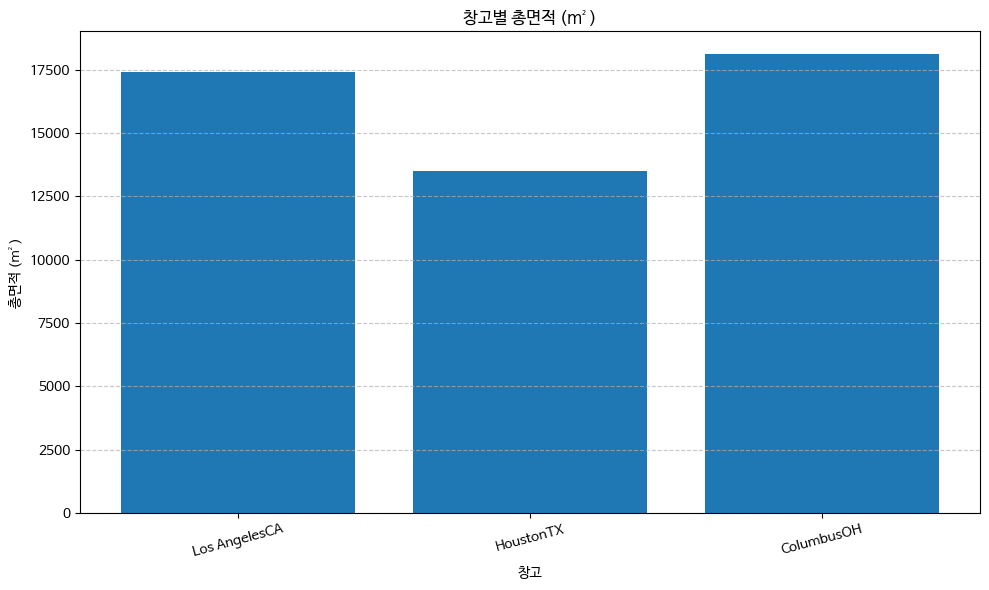

면적 산정 완료. 결과 파일 저장 위치: /content/sample_data/파이썬면적산정결과.xlsx
       Warehouse  연간 판매 목표량(Box)  (보정) 연 평균재고(Box)  (보정) 연 평균재고(Pallet)  \
0  Los AngelesCA         3100623            447536                11188   
1      HoustonTX         2407766            347531                 8688   
2     ColumbusOH         3228414            465981                11650   

   보관면적(m2)  입출고장(m2)  기타 공간 면적(m2)  총면적(m2)  
0     13426      1072          2900    17397  
1     10426       832          2252    13510  
2     13979      1116          3019    18114  


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# 파일 경로
optimization_result_path = '/content/sample_data/OptimizationResult수정MIP.xlsx'
area_simulation_path = '/content/sample_data/면적산정시뮬레이션.xlsx'
output_path = '/content/sample_data/파이썬면적산정결과.xlsx'

# 시트 로드
wh_data = pd.read_excel(optimization_result_path, sheet_name='WH')
parameter_data = pd.read_excel(area_simulation_path, sheet_name='면적산정 파라미터')

# 파라미터 딕셔너리 변환
parameters = parameter_data.set_index('항목')['값'].to_dict()

# 파라미터 값 추출
avg_inventory_turnover = parameters['평균 재고 회전율(연)']
warehouse_count = parameters['창고 개수']
inventory_increase_ratio = parameters['재고증가비율']
boxes_per_pallet = parameters['Pallet당 적재 Box 수 (개/PLT)']
monthly_inout_days = parameters['입출고 일수(월간)']
storage_unit_area = parameters['보관 원단위(m2/Pallet)']
inout_unit_area = parameters['입출고 원단위(m2/Pallet)']
etc_area_ratio = parameters['기타 공간 비율']

# 면적 산정 계산
results = []

for _, row in wh_data.iterrows():
    warehouse = row['Warehouse']
    total_cargo = row['TotalCargo']

    avg_inventory_box = (total_cargo / avg_inventory_turnover) * inventory_increase_ratio
    avg_inventory_pallet = avg_inventory_box / boxes_per_pallet
    storage_area = avg_inventory_pallet * storage_unit_area

    daily_inout_pallet = total_cargo / (monthly_inout_days * 12) / boxes_per_pallet
    inout_area = daily_inout_pallet * inout_unit_area

    etc_area = (storage_area + inout_area) * etc_area_ratio
    total_area = storage_area + inout_area + etc_area

    results.append({
        'Warehouse': warehouse,
        '연간 판매 목표량(Box)': round(total_cargo),
        '(보정) 연 평균재고(Box)': round(avg_inventory_box),
        '(보정) 연 평균재고(Pallet)': round(avg_inventory_pallet),
        '보관면적(m2)': round(storage_area),
        '입출고장(m2)': round(inout_area),
        '기타 공간 면적(m2)': round(etc_area),
        '총면적(m2)': round(total_area)
    })

# 결과 DataFrame
area_df = pd.DataFrame(results)

# 결과 저장
with pd.ExcelWriter(output_path, engine='openpyxl') as writer:
    area_df.to_excel(writer, sheet_name='면적', index=False)
    parameter_data.to_excel(writer, sheet_name='파라미터', index=False)

# 시각화 - 창고별 총면적
plt.figure(figsize=(10, 6))
plt.bar(area_df['Warehouse'], area_df['총면적(m2)'])
plt.title('창고별 총면적 (m²)')
plt.xlabel('창고')
plt.ylabel('총면적 (m²)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

# 출력 확인
print("면적 산정 완료. 결과 파일 저장 위치:", output_path)
print(area_df)

